In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = './data/housing_poland.csv'
CSV_ENCODING = 'ISO-8859-2'
CSV_SEPARATOR = ','

### Load and preprocess data

In [43]:
def get_haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [108]:
from datetime import datetime

data = pd.read_csv(CSV_PATH, sep=CSV_SEPARATOR, encoding=CSV_ENCODING)
data = data.drop(columns=['Unnamed: 0'])
data = data.dropna()

cities = pd.get_dummies(data['city']) 
data = data.join(cities)
data = data.drop(columns=['address', 'city', 'id'])

latlong_dict = {
    'Kraków': [50.03, 19.56],
    'Poznań': [52.24, 16.55],
    'Warszawa': [52.13, 21.00]
}

for city, (lat_city, lon_city) in latlong_dict.items():
    column_name = f'distance_to_{city}'
    data[column_name] = data.apply(lambda row: get_haversine_distance(row['latitude'], row['longitude'], lat_city, lon_city), axis=1)

data['distance_to_center'] = data[[f'distance_to_{city}' for city in latlong_dict.keys()]].min(axis=1)
data = data[data['distance_to_center'] < 200]
data['age'] = datetime.now().year - data['year']
data = data.drop(columns=[f'distance_to_{city}' for city in latlong_dict.keys()])
data = data.drop(columns=['year'])
data['sq_per_room'] = data['sq'] / data['rooms']

data

,floor,latitude,longitude,price,rooms,sq,Kraków,Poznań,Warszawa,distance_to_center,age,sq_per_room
0,2.0,50.049224,19.970379,749000.0,3.0,74.05,True,False,False,29.385388,3.0,24.683333
1,3.0,52.249775,21.106886,240548.0,1.0,24.38,False,False,True,15.181087,3.0,24.380000
2,2.0,50.066964,19.920025,427000.0,2.0,37.00,True,False,False,26.033211,54.0,18.500000
3,2.0,52.404212,16.882542,1290000.0,5.0,166.00,False,True,False,29.055450,89.0,33.200000
4,1.0,52.212225,20.972630,996000.0,5.0,105.00,False,False,True,9.331585,4.0,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
23759,0.0,52.449649,16.949408,543000.0,4.0,77.00,False,True,False,35.771063,4.0,19.250000
23760,4.0,52.186109,20.948438,910000.0,3.0,71.00,False,False,True,7.162267,7.0,23.666667
23761,0.0,52.397345,16.961939,430695.0,3.0,50.67,False,True,False,33.016317,2.0,16.890000
23762,6.0,50.024231,19.959569,359000.0,2.0,38.86,True,False,False,28.550145,3.0,19.430000


### Plots

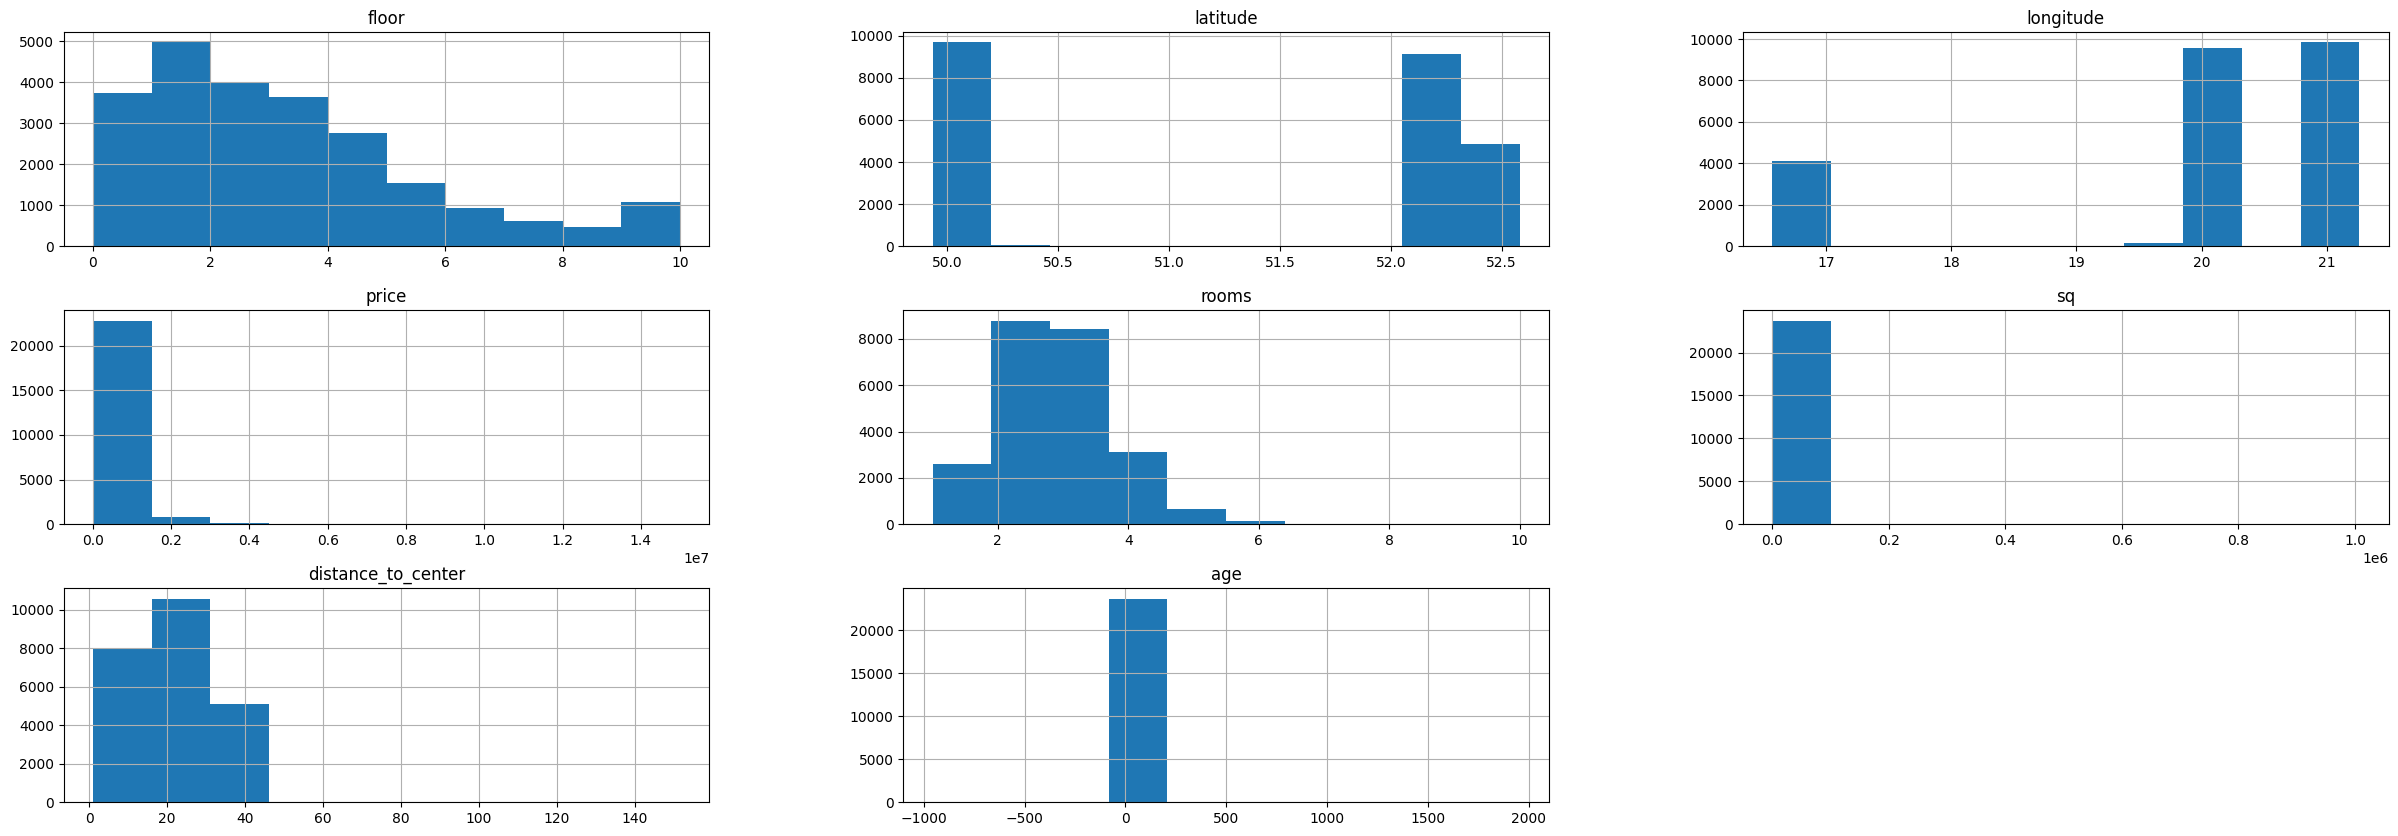

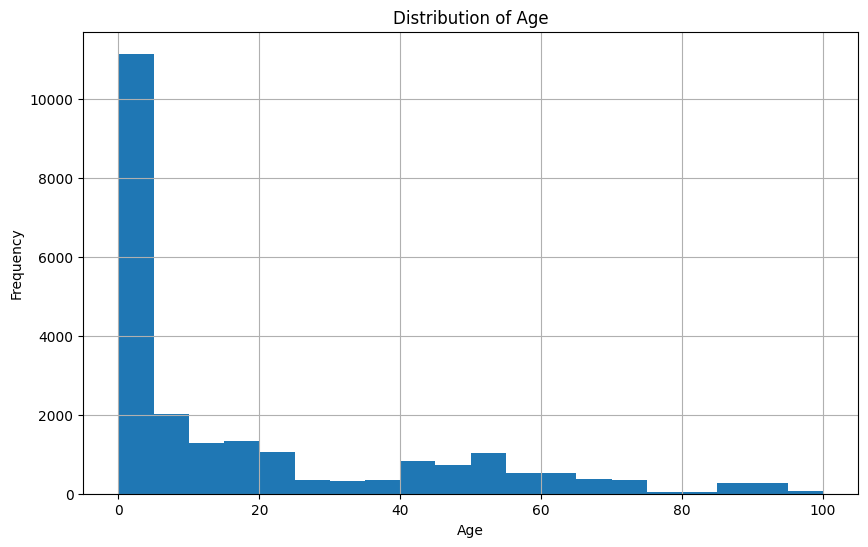

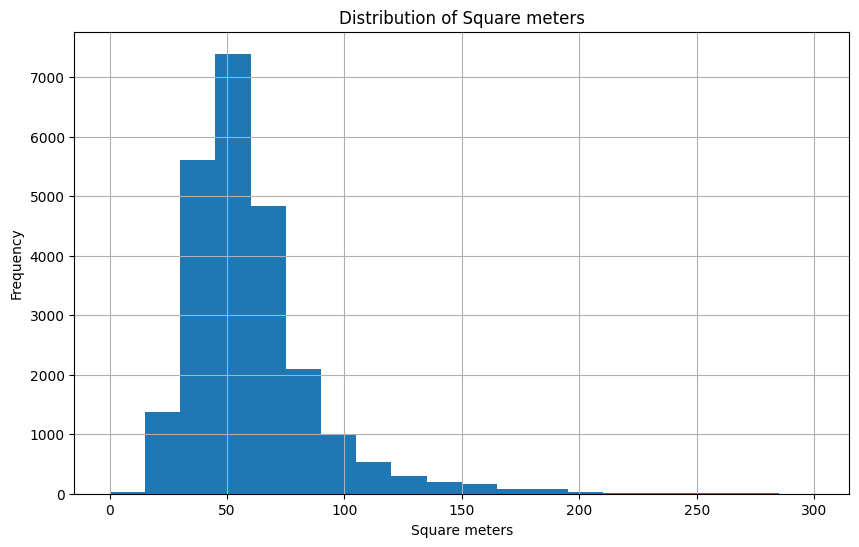

In [107]:
data.hist(figsize=(30,10))
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=20, range=(0, 100))  # Adjust range as necessary
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(data['sq'], bins=20, range=(0, 300))  # Adjust range as necessary
plt.xlabel('Square meters')
plt.ylabel('Frequency')
plt.title('Distribution of Square meters')
plt.grid(True)
plt.show()

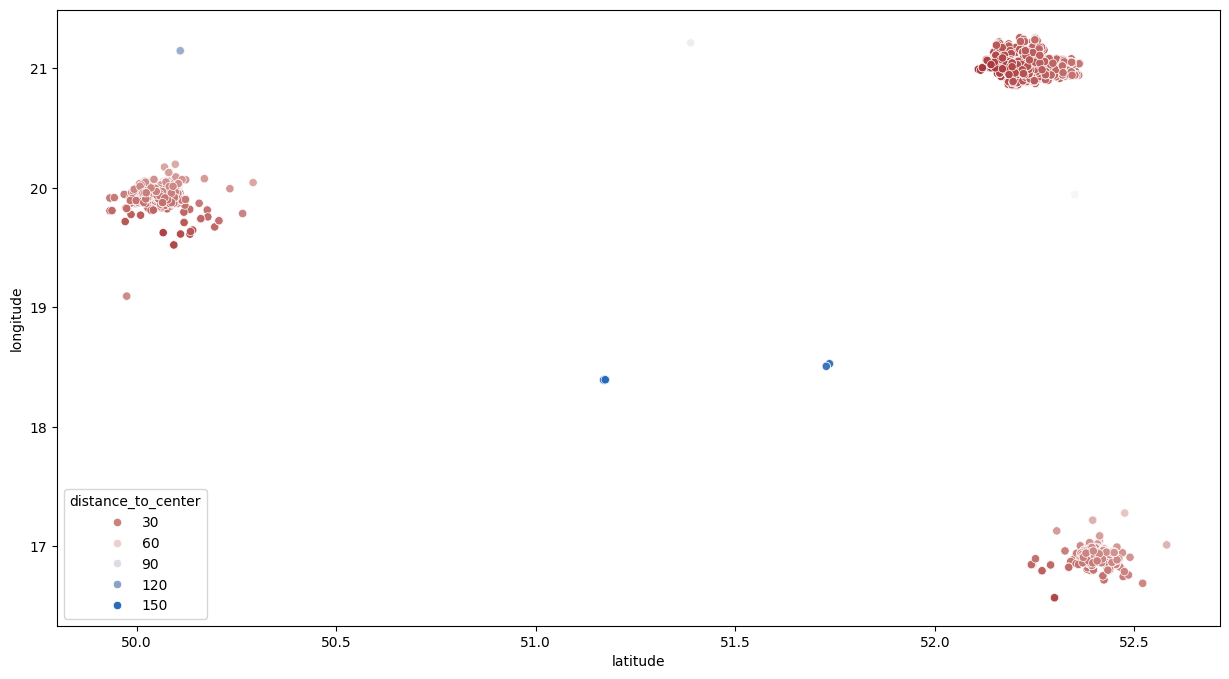

In [80]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='latitude', y='longitude', data=data, hue='distance_to_center', palette='vlag_r')
plt.show()

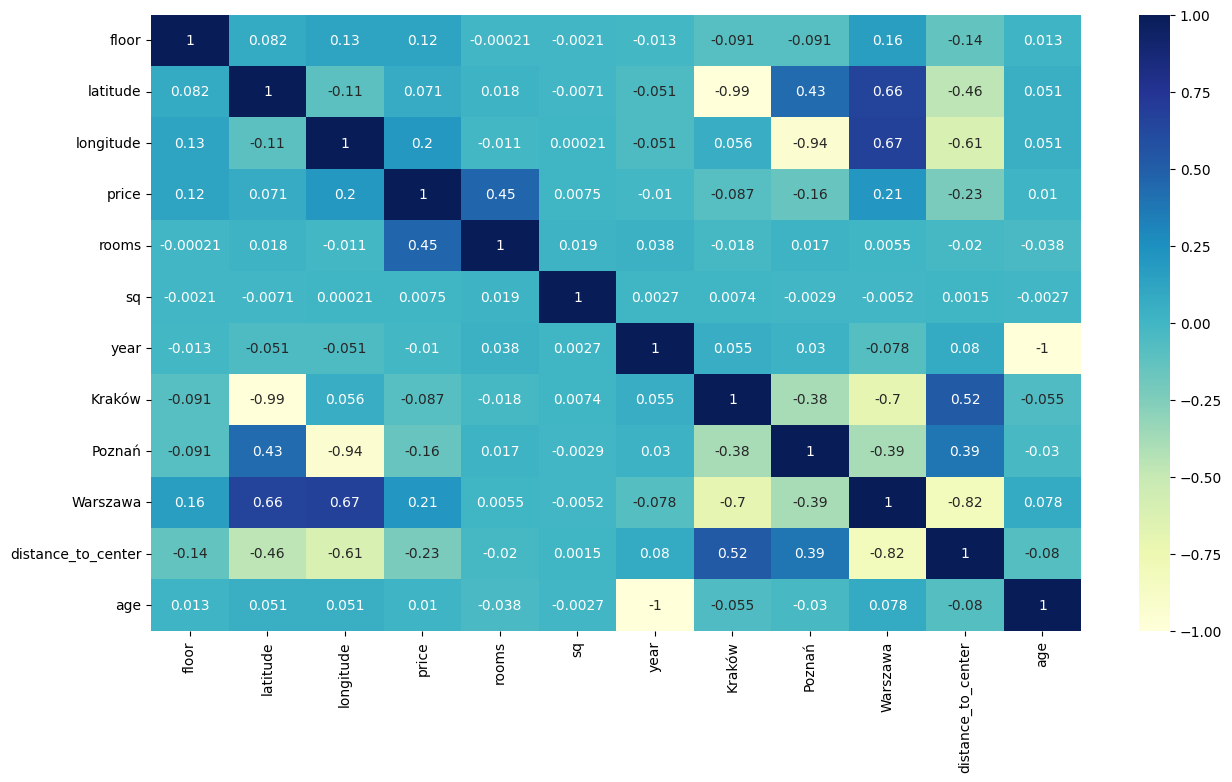

In [86]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.show()

### Training & Eval

In [109]:
from sklearn.model_selection import train_test_split

xs = data.drop(['price'], axis=1)
xs = xs.to_numpy()
ys = data['price']
ys = ys.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2)

print('train:')
print(x_train.shape)
print(y_train.shape)
print()
print('test:')
print(x_test.shape)
print(y_test.shape)

train:
(18989, 11)
(18989,)

test:
(4748, 11)
(4748,)


In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = LinearRegression()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

score = model.score(x_test, y_test)
print(f'Score: {score}')
print(f'RMSE Score: {rmse}')
print(f'Mean house price: {np.mean(y_test)}')
print(f'RMSE of Mean house price %: {(rmse / np.mean(y_test)) * 100}%')

Score: -217.2609189915978
RMSE Score: 7754081.968837065
Mean house price: 653654.3871251054
RMSE of Mean house price %: 1186.2663391491906%
